## Project One A: Non-linear Modeling and Simulation of Housing Prices.

Due: 20th April, 2025

## GROUP MEMBERS (Group 10):

- Elizabeth Avevor Afful

- Peniel Maame Akyireko Ansah

- Kevin Cudjoe

- Nana Kwaku Amoako

- Steve Nsabimana



## Objective:
This project aims to model and simulate housing prices using non-linear regression techniques such as polynomial regression, exponential models, or spline interpolation.

We will analyze a real-world housing dataset, explore relationships between variables, fit a non-linear model, perform predictions, and evaluate the model's performance.

This project will also involve simulating price trends based on hypothetical changes in key factors like location demand, economic conditions, or property features.

We will use a real-world dataset on housing pricing,  which was obtained from Kaggle.com

The dataset has train.csv and test.csv

## Reference: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=sample_submission.csv


### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
!pip install lightgbm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
from scipy.interpolate import UnivariateSpline, splrep, splev
warnings.filterwarnings('ignore')

## Data Collection (Kaggle.com)

In [ ]:
data = pd.read_csv('train.csv')
print("The first 5 rows of the dataset include:")
data.head()

The first 5 rows of the dataset include:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print("Dataset information:")
print(data.info())

print("\nSummary statistics for the dataset for the features:")
print(data.describe())

# From the results below, there are 1460 rows of different houses and 81 columns of the different features or factors(columns)
# Data types present: 3 float values, 35 integer values and 43 objects

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   

## QUESTION TWO: DATA PREPROCESSING

### Handling Missing Values

In [ ]:
# Function to handle missing values and outliers
def handle_missing_values_and_outliers(df):
    """
    Goal: To handle missing values and outliers in the dataset
    """
    print("\n--- Handling Missing Values ---")

    # Check for missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_values,
                               'Percentage': missing_percent})
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

    # We handled the missing values accordingly
    # For numerical columns, we filled the NaN values with the median
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    # For categorical, we filled with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Check if there are outstanding missing values
    print("\nRemaining missing values:")
    print(df.isnull().sum().sum())

    print("\n--- Handling Outliers ---")
    # We used the IQR method for handling outliers for numerical variables
    # We'll focus on a few important variables like LotArea, GrLivArea, and TotalBsmtSF
    key_numeric_cols = ['LotArea', 'GrLivArea', 'TotalBsmtSF']

    for col in key_numeric_cols:
        if col in df.columns:
            # IQR Calculation
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            #Outlier bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            print(f"Column {col} has {len(outliers)} outliers")

            # Cap outliers instead of removing them
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# Applying the function to handle missing values and outliers
data = handle_missing_values_and_outliers(data)


--- Handling Missing Values ---
              Missing Values  Percentage
PoolQC                  1453   99.520548
MiscFeature             1406   96.301370
Alley                   1369   93.767123
Fence                   1179   80.753425
MasVnrType               872   59.726027
FireplaceQu              690   47.260274
LotFrontage              259   17.739726
GarageType                81    5.547945
GarageYrBlt               81    5.547945
GarageFinish              81    5.547945
GarageQual                81    5.547945
GarageCond                81    5.547945
BsmtExposure              38    2.602740
BsmtFinType2              38    2.602740
BsmtQual                  37    2.534247
BsmtCond                  37    2.534247
BsmtFinType1              37    2.534247
MasVnrArea                 8    0.547945
Electrical                 1    0.068493

Remaining missing values:
0

--- Handling Outliers ---
Column LotArea has 69 outliers
Column GrLivArea has 31 outliers
Column TotalBsmtSF has 61 o

### **Interpreting the skewness of the SalePrice:**

The skewness of the orgnal salePrice is approximately 1.883
This value is positive and relatively high, meaning the distribution of SalePrice is right-skewed(positively skewed)

This means there are more houses with lower prices, and a few houses with very high prices pulling the distribution to the right, as seen from the plot.

The bulk of the data is concentrated on the left (the lower prices).

The mean of the SalePrice is greater than the median. That is:
##180921.195890 >  163000.000000




### Exploratory Data Analysis


--- Data Distribution Exploration ---
Skewness of SalePrice: 1.8828757597682129


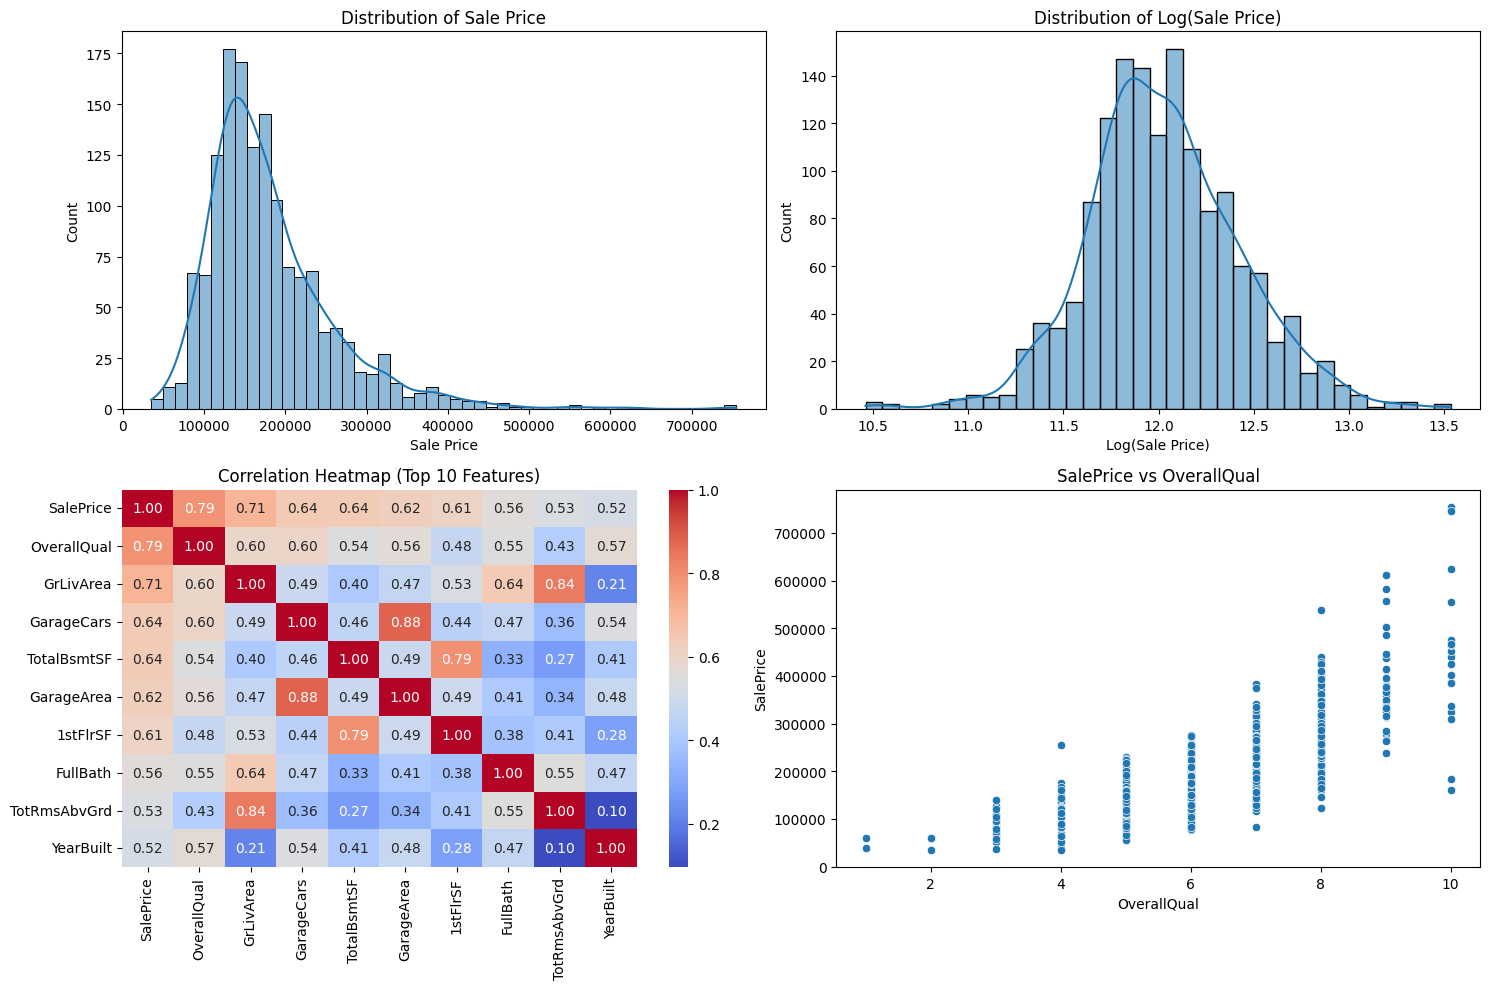

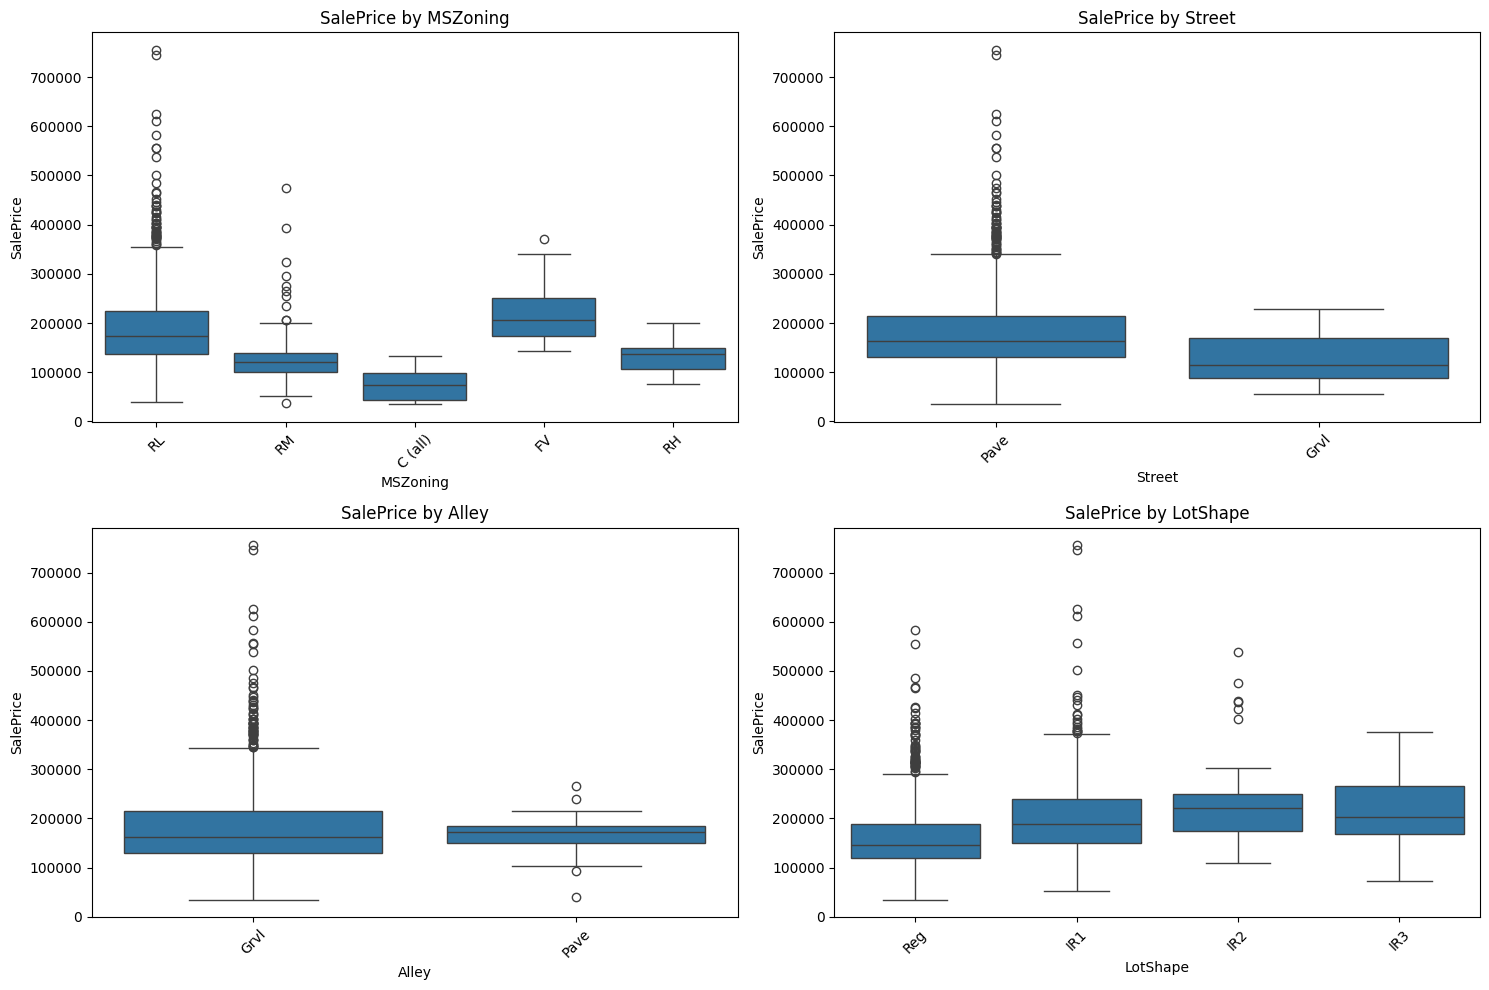

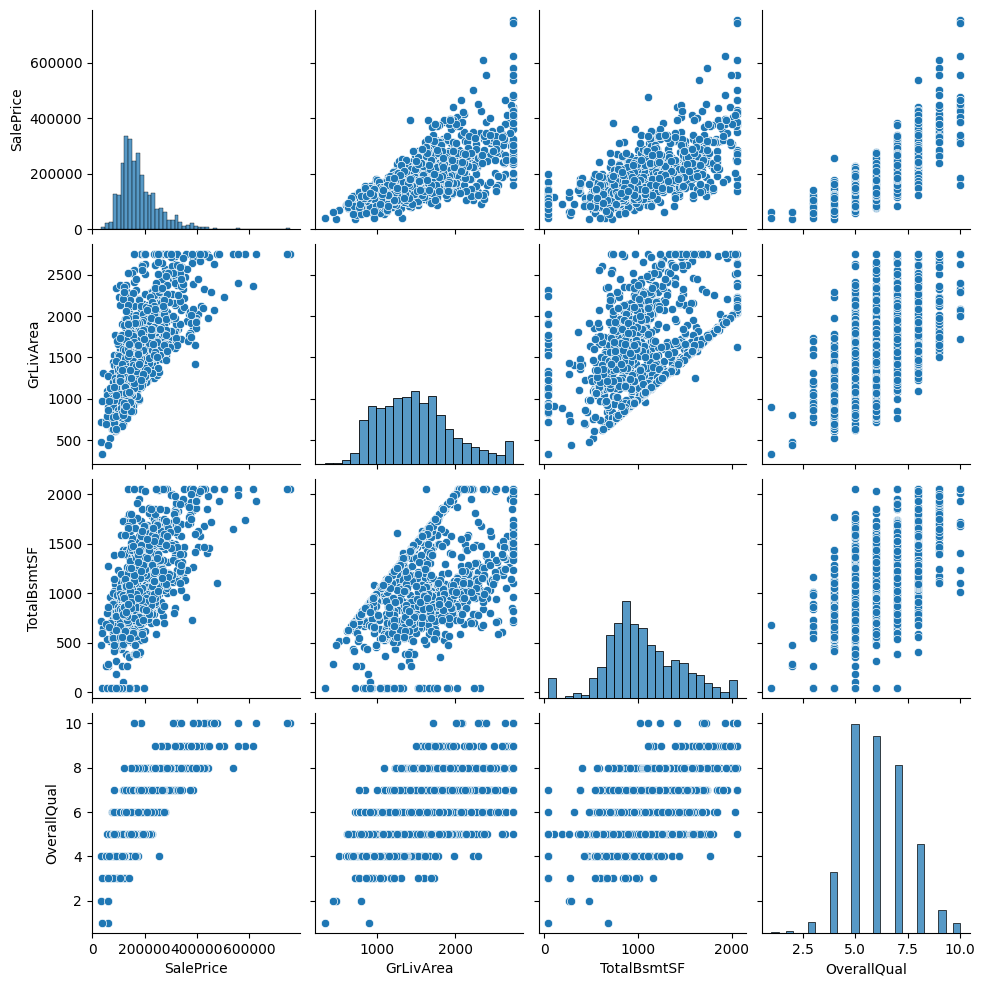

In [ ]:
# Function for Exploratory Data Analysis
def explore_data_distribution(df):
    """
    Goal: Explore data distribution and relationships using visualizations
    """
    print("\n--- Data Distribution Exploration ---")


    plt.figure(figsize=(15, 10))

    # 'SalePrice' is the target variable we are interested in
    if 'SalePrice' in df.columns:
        # Distribution of the target variable (SalePrice)
        plt.subplot(2, 2, 1)
        sns.histplot(df['SalePrice'], kde=True)
        plt.title('Distribution of Sale Price')
        plt.xlabel('Sale Price')

        # Check if SalePrice is skewed
        skewness = df['SalePrice'].skew()
        print(f"Skewness of SalePrice: {skewness}")

        # Log transformation of SalePrice
        plt.subplot(2, 2, 2)
        sns.histplot(np.log1p(df['SalePrice']), kde=True)
        plt.title('Distribution of Log(Sale Price)')
        plt.xlabel('Log(Sale Price)')

        # Create a heatmap of correlation between numeric features
        plt.subplot(2, 2, 3)
        numeric_data = df.select_dtypes(include=['float64', 'int64'])

        # Select top 10 features correlated with SalePrice
        corr_matrix = numeric_data.corr()
        top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10).index
        sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap (Top 10 Features)')

        # Scatter plot of the most correlated feature with SalePrice
        plt.subplot(2, 2, 4)
        most_correlated = corr_matrix['SalePrice'].abs().sort_values(ascending=False).index[1]  # [0] would be SalePrice itself
        sns.scatterplot(x=most_correlated, y='SalePrice', data=df)
        plt.title(f'SalePrice vs {most_correlated}')

        plt.tight_layout()
        plt.savefig('data_distribution.png')
        plt.show()

        # Additional visualizations
        # Boxplots of categorical variables vs SalePrice
        plt.figure(figsize=(15, 10))
        categorical_cols = df.select_dtypes(include=['object']).columns[:4]  # Take first 4 categorical columns as example
        for i, col in enumerate(categorical_cols, 1):
            plt.subplot(2, 2, i)
            sns.boxplot(x=col, y='SalePrice', data=df)
            plt.title(f'SalePrice by {col}')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig('categorical_vs_saleprice.png')

        # Pairplot for key numerical features
        key_features = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'OverallQual']
        if all(feature in df.columns for feature in key_features):
            sns.pairplot(df[key_features])
            plt.savefig('pairplot.png')

    else:
        print("SalePrice column not found in the dataset.")    #present in the train.csv set but not the test.csv

# Applying the function to explore data distribution (Images save as png files in directory)
explore_data_distribution(data)

### Transformations


--- Performing Transformations ---
Found 10 skewed columns
LotFrontage: Skewness = 2.41
SalePrice: Skewness = 1.88
MSSubClass: Skewness = 1.41
1stFlrSF: Skewness = 1.38
OverallCond: Skewness = 0.69
GarageYrBlt: Skewness = -0.68
TotRmsAbvGrd: Skewness = 0.68
YearBuilt: Skewness = -0.61
GrLivArea: Skewness = 0.59
YearRemodAdd: Skewness = -0.50


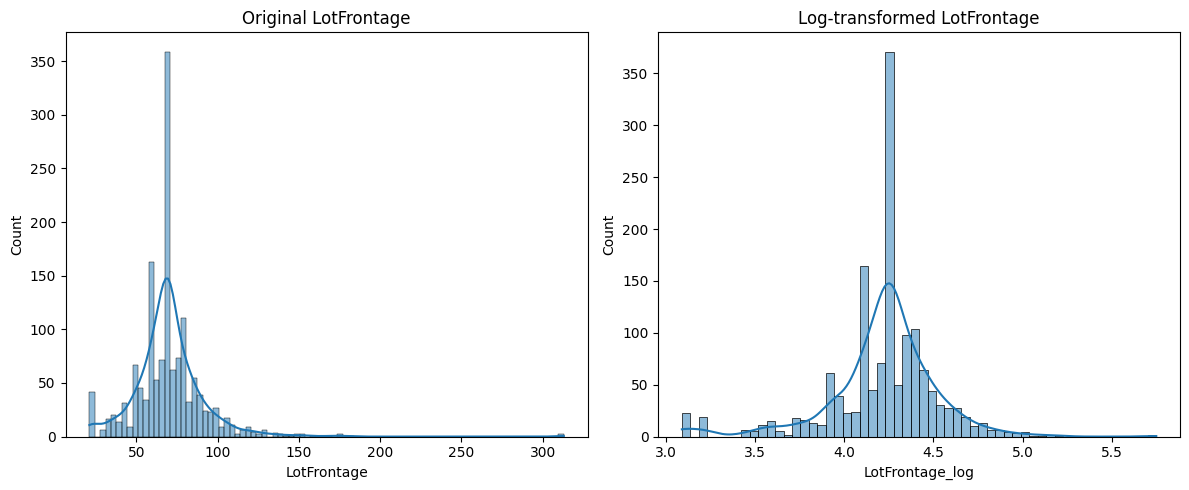

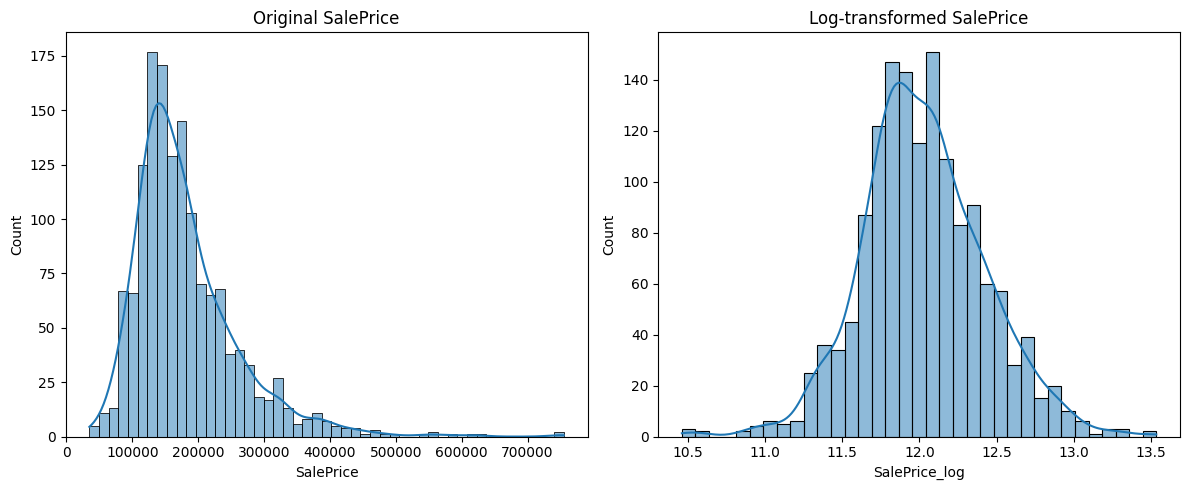

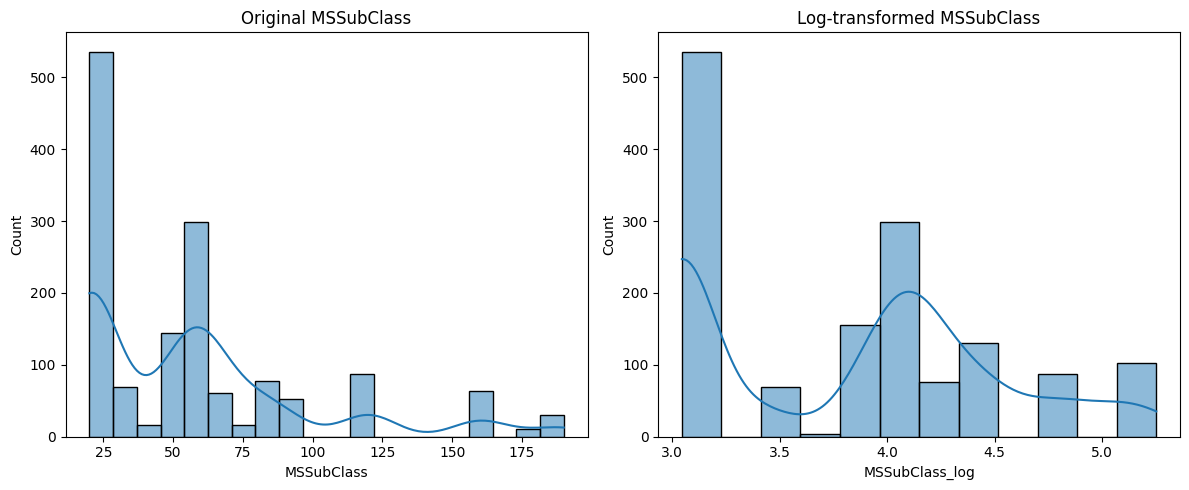

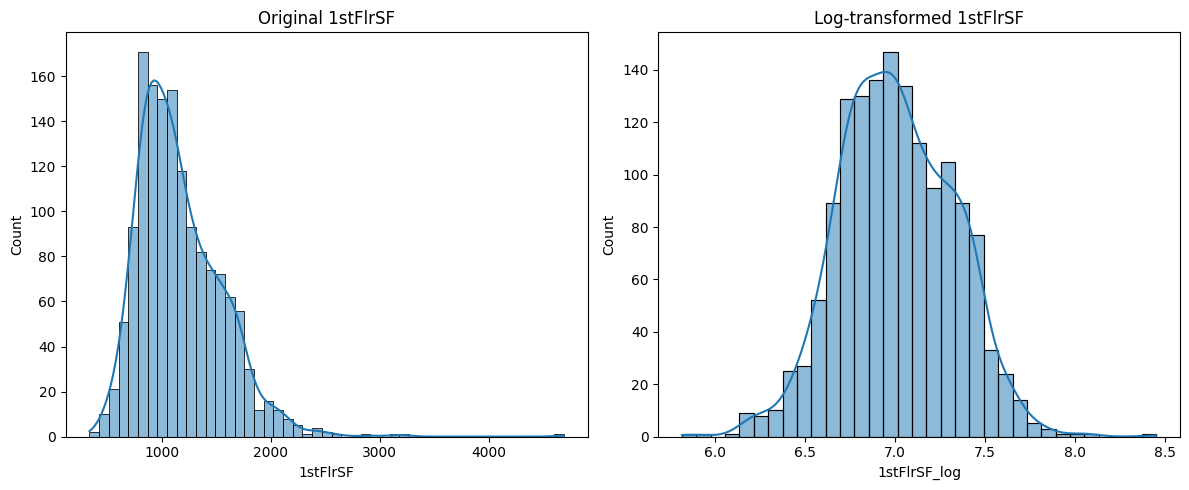

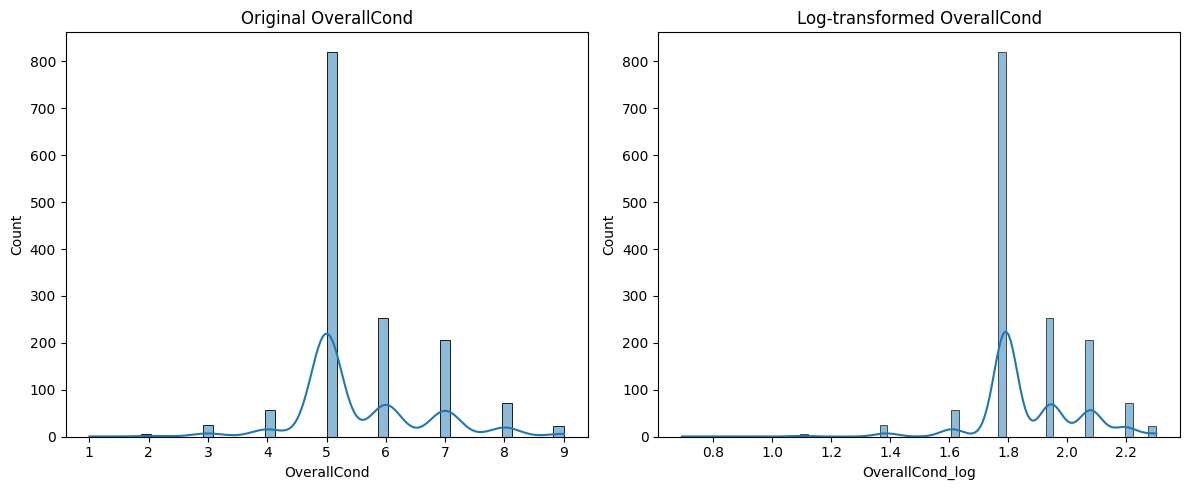

In [ ]:
# Function to perform transformations
def perform_transformations(df):
    """
    Goal: Perform transformations on skewed variables
    """
    print("\n--- Performing Transformations ---")

    # Create a copy of the dataframe to store transformed data
    transformed_df = df.copy()

    # Check for skewness in numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    skewed_cols = []

    for col in numeric_cols:
        # Skip columns with zeros or negative values for log transformation
        if (df[col] <= 0).any():
            continue

        skewness = df[col].skew()
        # Consider columns with skewness > 0.5 as skewed
        if abs(skewness) > 0.5:
            skewed_cols.append((col, skewness))

    # Sort by skewness for better visualization
    skewed_cols.sort(key=lambda x: abs(x[1]), reverse=True)

    print(f"Found {len(skewed_cols)} skewed columns")
    for col, skew in skewed_cols[:10]:  # Display top 10 skewed columns
        print(f"{col}: Skewness = {skew:.2f}")

    # Apply log transformation to skewed columns
    for col, _ in skewed_cols:
        # Ensure all values are positive for log transformation
        if (df[col] <= 0).any():
            continue

        # Apply log transformation
        transformed_df[f'{col}_log'] = np.log1p(df[col])

        # Visualize before and after transformation for top 5 skewed columns
        if col in [x[0] for x in skewed_cols[:5]]:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            sns.histplot(df[col], kde=True)
            plt.title(f'Original {col}')

            plt.subplot(1, 2, 2)
            sns.histplot(transformed_df[f'{col}_log'], kde=True)
            plt.title(f'Log-transformed {col}')

            plt.tight_layout()
            plt.savefig(f'transformation_{col}.png')

    # If SalePrice exists, transform it as well
    if 'SalePrice' in df.columns:
        transformed_df['SalePrice_log'] = np.log1p(df['SalePrice'])

    return transformed_df

# Apply transformations to the data
transformed_data = perform_transformations(data)

## QUESTION THREE: CHOOSING A (SINGLE) NON-LINEAR MODEL

In [ ]:
def prepare_features_and_target(df):
    """
    Goal: Prepare the features and target(SalePrice) for modeling
    """
    #  SalePrice is the target
    if 'SalePrice' in df.columns:
        y = df['SalePrice']
        X = df.drop('SalePrice', axis=1)

        # Handle categorical variables
        X = pd.get_dummies(X, drop_first=True)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        return X_train, X_test, y_train, y_test
    else:
        print("SalePrice column not found in the dataset.")
        return None, None, None, None

In [ ]:
# Create copies for different modeling approaches
data_for_polynomial = data.copy()
data_for_log = transformed_data.copy()

### Polynomial Regression: Captures curvilinear relationships

In [ ]:
# Function for polynomial regression
def polynomial_regression(df):
    """
    Goal: Implement polynomial regression to capture curivilinear relationships
    """
    print("\n--- Polynomial Regression ---")

    X_train, X_test, y_train, y_test = prepare_features_and_target(df)

    if X_train is None:
        return None
    print(df)


    # selecting the most important features to avoid memory issues by using correlation and basic feature selection technique
    corr_with_target = abs(pd.concat([X_train, y_train], axis=1).corr()['SalePrice']).sort_values(ascending=False)
    top_features = corr_with_target[1:11].index
    print(top_features)

    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Try different degrees of polynomial
    degrees = [1, 2, 3]  # Starting with simpler models
    results = []

    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)

        # Fit linear regression on polynomial features
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)

        # Calculate metrics to assess the performance of the models
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        results.append({
            'Degree': degree,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train R²': train_r2,
            'Test R²': test_r2
        })

        print(f"Polynomial Degree {degree}:")
        print(f"  Train RMSE: {train_rmse:.2f}")
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Test R²: {test_r2:.4f}")

    # Best model based on test R²
    best_model_idx = max(range(len(results)), key=lambda i: results[i]['Test R²'])
    best_degree = results[best_model_idx]['Degree']

    print(f"\nBest Polynomial Model: Degree {best_degree}")
    print(f"  Test RMSE: {results[best_model_idx]['Test RMSE']:.2f}")
    print(f"  Test R²: {results[best_model_idx]['Test R²']:.4f}")

    # Return the best model results
    return {
        'model_type': 'Polynomial Regression',
        'degree': best_degree,
        'test_rmse': results[best_model_idx]['Test RMSE'],
        'test_r2': results[best_model_idx]['Test R²']
    }

# Implement polynomial regression
poly_results = polynomial_regression(data_for_polynomial)


--- Polynomial Regression ---
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0   8450.0   Pave  Grvl      Reg   
1        2          20       RL         80.0   9600.0   Pave  Grvl      Reg   
2        3          60       RL         68.0  11250.0   Pave  Grvl      IR1   
3        4          70       RL         60.0   9550.0   Pave  Grvl      IR1   
4        5          60       RL         84.0  14260.0   Pave  Grvl      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0   7917.0   Pave  Grvl      Reg   
1456  1457          20       RL         85.0  13175.0   Pave  Grvl      Reg   
1457  1458          70       RL         66.0   9042.0   Pave  Grvl      Reg   
1458  1459          20       RL         68.0   9717.0   Pave  Grvl      Reg   
1459  1460          20       RL         75.0   9937.0   Pave  Grvl      Reg   

     LandContour Uti

### Interpretation:
From the reults above the best polynomial model out of the 3 is the second degree polynomial

It has the highest Test R2 score of **0.8399** among the three, indicating that the model explains about **83.99%** of the variability in the house prices.

It also has the lowest RMSE value of **$35040.37**

This is a measure of how far off the 2nd degree polynomial's predictions are from the actual house prices, on average. And since it is the lowest, it is better than the rest

###  Exponential or Logarithmic Models: Suitable for price trends influenced by exponential growth


--- Exponential/Logarithmic Model ---
Exponential Model Results:
  Train RMSE: 32083.79
  Test RMSE: 36017.41
  Train R²: 0.8274
  Test R²: 0.8309


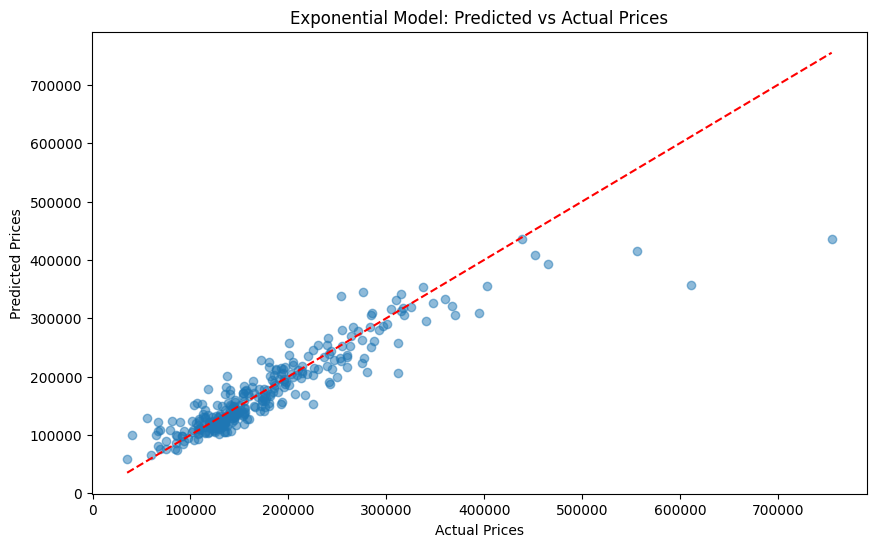

In [ ]:
# Function for the exponential model
def exponential_model(df):
    """
    Goal: Implement exponential/logarithmic model using log-transformed target
    """
    print("\n--- Exponential/Logarithmic Model ---")

    # we are using the log-transformed target for the exponential model
    if 'SalePrice_log' in df.columns:
        # copy with log-transformed target is created
        df_log = df.copy()
        df_log['SalePrice'] = df_log['SalePrice_log']
        df_log.drop('SalePrice_log', axis=1, inplace=True)

        X_train, X_test, y_train_log, y_test_log = prepare_features_and_target(df_log)

        if X_train is None:
            return None

        # Select top 10 important features
        corr_with_target = abs(pd.concat([X_train, y_train_log], axis=1).corr()['SalePrice']).sort_values(ascending=False)
        top_features = corr_with_target[1:11].index

        X_train_selected = X_train[top_features]
        X_test_selected = X_test[top_features]

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)

        # Fit linear regression on log-transformed target
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_log)

        # Make predictions. It is still in the log scale
        y_train_pred_log = model.predict(X_train_scaled)
        y_test_pred_log = model.predict(X_test_scaled)

        # Transform predictions back to original scale
        y_train_pred = np.expm1(y_train_pred_log)
        y_test_pred = np.expm1(y_test_pred_log)

        # Get original scale targets
        y_train = np.expm1(y_train_log)
        y_test = np.expm1(y_test_log)

        # Calculate metrics on original scale
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print("Exponential Model Results:")
        print(f"  Train RMSE: {train_rmse:.2f}")
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Test R²: {test_r2:.4f}")

        # Visualize predictions vs actual
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.title('Exponential Model: Predicted vs Actual Prices')
        plt.savefig('exponential_model_predictions.png')

        return {
            'model_type': 'Exponential/Logarithmic Model',
            'test_rmse': test_rmse,
            'test_r2': test_r2
        }

    else:
        print("SalePrice_log column not found. Make sure transformations were applied.")
        return None

# Implement exponential model
exp_results = exponential_model(data_for_log)

## Interpretation:
The exponential model has a Test R2 score of **0.8309**, indicating that the model explains about 83.09% of the variability in the house prices.

It also has a Test Root Mean Squared Error of **36017.41**

### Original Spline Interpolation


--- Spline Interpolation Model ---

Fitting univariate spline for OverallQual...
  Train RMSE: 197194.28
  Test RMSE: 199133.13
  Train R²: -5.5194
  Test R²: -4.1698

Fitting univariate spline for GrLivArea...
  Train RMSE: 197194.28
  Test RMSE: 199133.13
  Train R²: -5.5194
  Test R²: -4.1698

Fitting univariate spline for GarageCars...
  Train RMSE: 197194.28
  Test RMSE: 199133.13
  Train R²: -5.5194
  Test R²: -4.1698


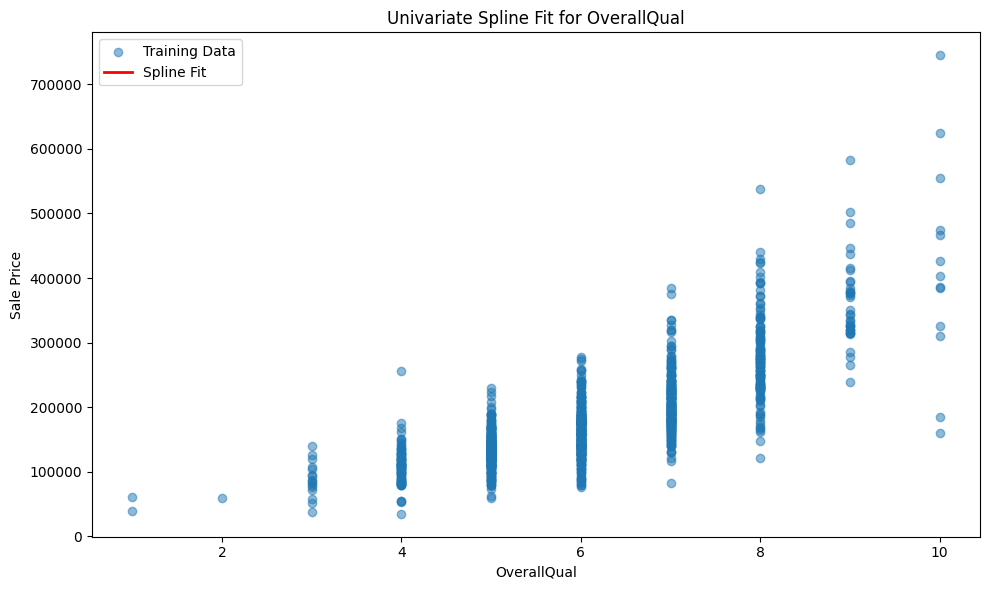

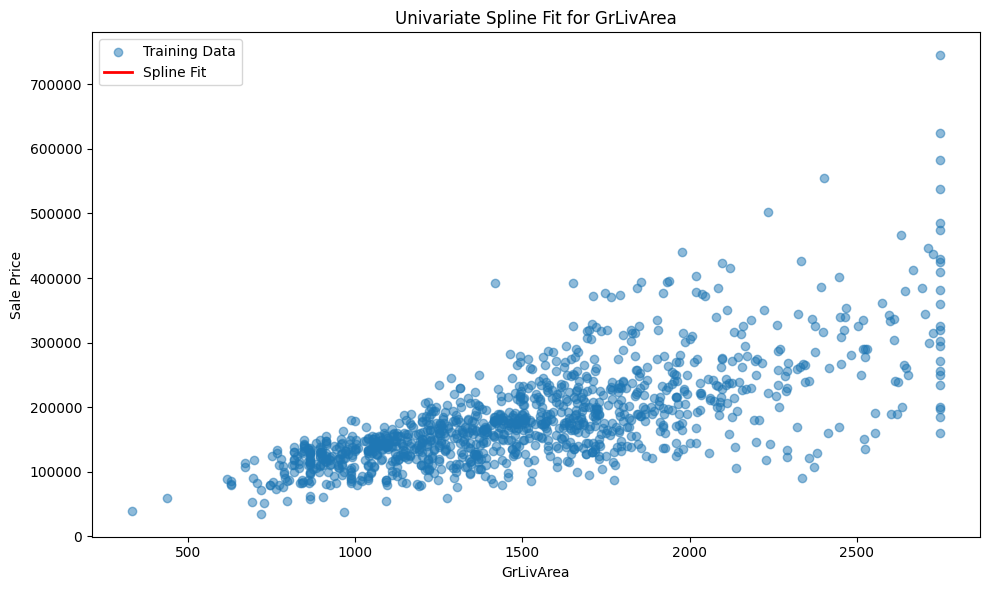

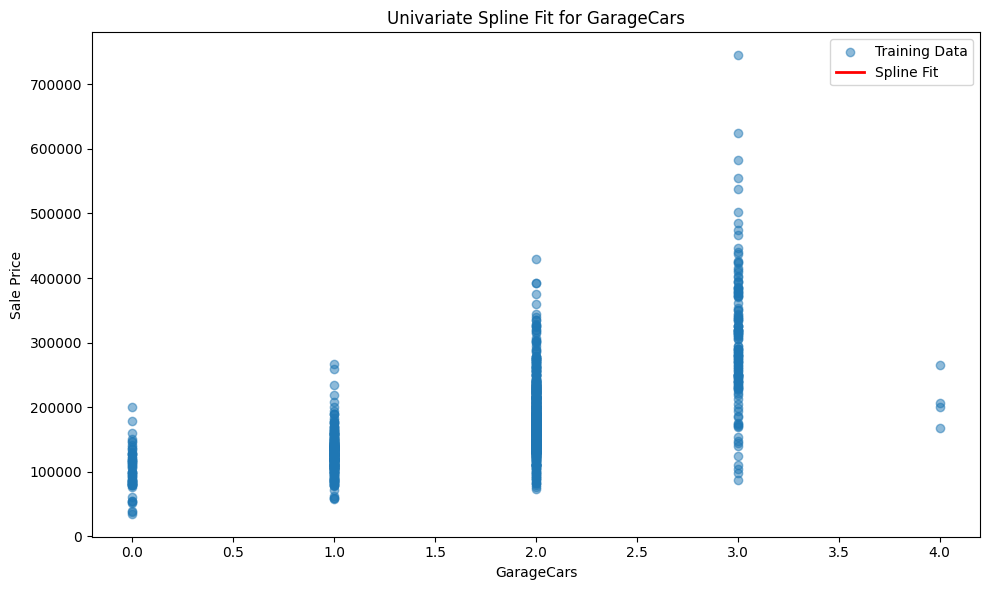

In [ ]:
def original_spline_model(df):
    """
    Implement actual spline interpolation instead of using Random Forest as a proxy
    """
    print("\n--- Spline Interpolation Model ---")


    X_train, X_test, y_train, y_test = prepare_features_and_target(df)

    if X_train is None:
        return None

    # we'll focus on the most correlated features with the target for the spline
    numeric_df = df.select_dtypes(include=['number'])
    corr_with_target = abs(numeric_df.corr()['SalePrice']).sort_values(ascending=False)

    # Let's use univariate splines for the top 3 most correlated features
    top_features = corr_with_target[1:4].index  # Top 3 features excluding SalePrice

    spline_results_list = []

    # Fit univariate splines for each top feature
    for feature in top_features:
        print(f"\nFitting univariate spline for {feature}...")

        # Get feature data
        X_train_feature = X_train[feature].values
        X_test_feature = X_test[feature].values

        # Sort training data for spline fitting
        sorted_indices = np.argsort(X_train_feature)
        X_train_sorted = X_train_feature[sorted_indices]
        y_train_sorted = y_train.values[sorted_indices]

        # Fit a univariate spline with smoothing
        # Use smoothing factor (s) that balances fit and smoothness
        spline = UnivariateSpline(X_train_sorted, y_train_sorted, s=len(X_train_sorted)*100)

        # Make predictions
        y_train_pred = spline(X_train_feature)
        y_test_pred = spline(X_test_feature)

        # Check and handle NaNs in predictions:
        y_train_pred = np.nan_to_num(y_train_pred)
        y_test_pred = np.nan_to_num(y_test_pred)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"  Train RMSE: {train_rmse:.2f}")
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Test R²: {test_r2:.4f}")

        spline_results_list.append({
            'feature': feature,
            'spline': spline,
            'test_rmse': test_rmse,
            'test_r2': test_r2
        })

        # Visualize the spline fit
        x_smooth = np.linspace(X_train_feature.min(), X_train_feature.max(), 100)
        y_smooth = spline(x_smooth)

        plt.figure(figsize=(10, 6))
        plt.scatter(X_train_feature, y_train, alpha=0.5, label='Training Data')
        plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Spline Fit')
        plt.xlabel(feature)
        plt.ylabel('Sale Price')
        plt.title(f'Univariate Spline Fit for {feature}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'spline_fit_{feature}.png')

spline_results = original_spline_model(data)

### Interpretation

The output shows the performance of a univariate spline interpolation model applied to three different features: OverallQual, GrLivArea, and GarageCars. However, the results indicate that the model performs very poorly on all three features:

The Root Mean Square Error (RMSE) is very high which suggests large prediction errors.

The R² scores are strongly negative which means the models are performing worse than simply predicting the mean of the target variable.

This indicates that spline interpolation is not suitable for modelling the relationship between these features and the target variable in this case. Hence we suggest the random forest.

### Random Forest Spline-Like


--- Spline-like Model (Random Forest) ---
Random Forest (Spline-like) Model Results:
  Train RMSE: 11707.52
  Test RMSE: 28902.98
  Train R²: 0.9770
  Test R²: 0.8911

Top 10 Most Important Features:
         Feature  Importance
0    OverallQual    0.566819
1      GrLivArea    0.137192
3    TotalBsmtSF    0.054236
5       1stFlrSF    0.050134
19       LotArea    0.031028
4     GarageArea    0.027614
9      YearBuilt    0.020522
12  YearRemodAdd    0.019763
2     GarageCars    0.016682
8   TotRmsAbvGrd    0.013614


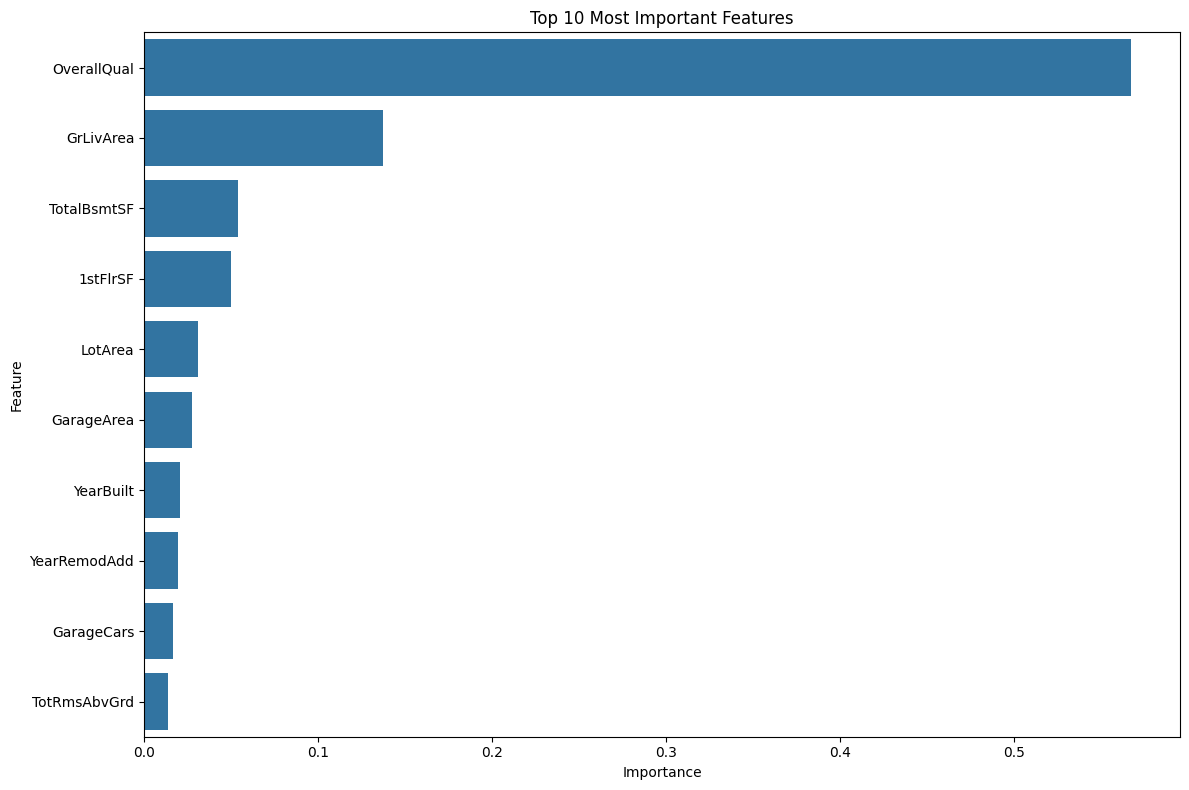

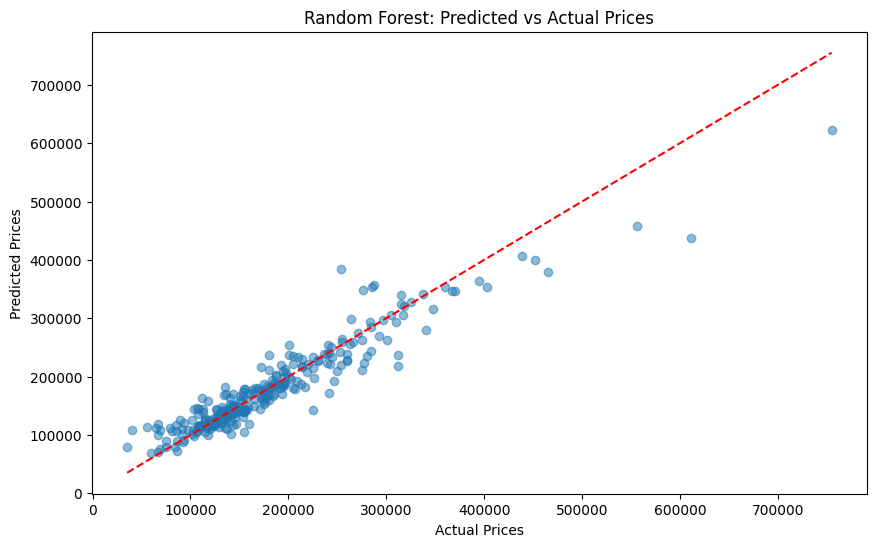

In [ ]:
## iii. Spline Interpolation: Breaks the dataset into smaller intervals and fits different functions to each
def random_forest(df):
    """
    Use Random Forest as a proxy for spline interpolation
    (True spline modeling would require specialized libraries, so RF serves as a flexible non-linear model)
    """
    print("\n--- Spline-like Model (Random Forest) ---")

    # Prepare data
    X_train, X_test, y_train, y_test = prepare_features_and_target(df)

    if X_train is None:
        return None

    # We are limiting the features for the random forest for faster training
    corr_with_target = abs(pd.concat([X_train, y_train], axis=1).corr()['SalePrice']).sort_values(ascending=False)
    top_features = corr_with_target[1:21].index

    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_selected, y_train)

    # Make predictions
    y_train_pred = rf_model.predict(X_train_selected)
    y_test_pred = rf_model.predict(X_test_selected)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("Random Forest (Spline-like) Model Results:")
    print(f"  Train RMSE: {train_rmse:.2f}")
    print(f"  Test RMSE: {test_rmse:.2f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")

    # Get feature importances
    feature_importances = pd.DataFrame({
        'Feature': top_features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importances.head(10))

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.savefig('feature_importances.png')

    # Visualize predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Random Forest: Predicted vs Actual Prices')
    plt.savefig('rf_model_predictions.png')

    return {
    'model_type': 'Random Forest (Spline-like)',
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'model': rf_model,
    'important_features': feature_importances,
    'feature_order': top_features.tolist()
    }

# Implement spline-like model
spline_results = random_forest(data)



### Interpretation:

The Random Forest model(which is Spline-like) has a test R2 score of 0.8911 which best among all the models. This means that, this model is able to explain about 89.11 of the variability on the houses.

Its **RMSE** is also the lowest(**28902.98**) indicating a better fit than the other models.

### Model Fitting and Predictions


--- Model Comparison ---
                           Model     Test RMSE   Test R²
0          Polynomial Regression  35040.374429  0.839925
1  Exponential/Logarithmic Model  36017.411575  0.830874
2    Random Forest (Spline-like)  28902.976695  0.891089

Best model: Random Forest (Spline-like)
  Test RMSE: 28902.98
  Test R²: 0.8911


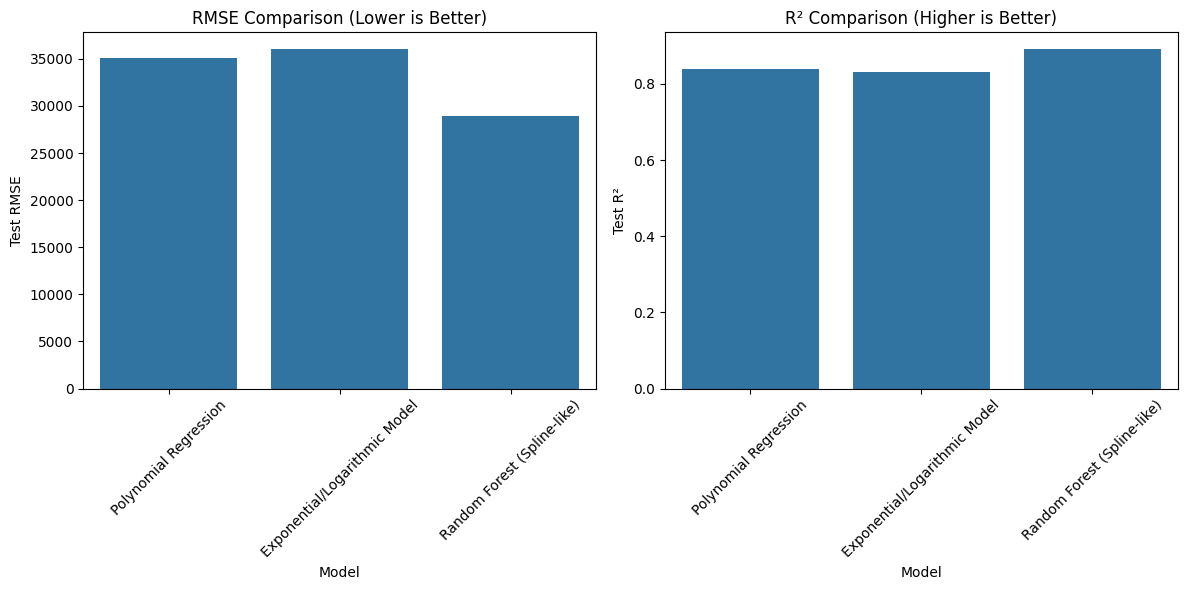

In [ ]:
# 4. Model Fitting and Predictions:

## i. Fit the chosen non-linear model(s) to the dataset (already done in previous steps)

## ii. Compare models based on their performance using metrics like R², RMSE, and residual analysis

def compare_models(results_list):
    """
    Compare different models based on performance metrics
    """
    print("\n--- Model Comparison ---")

    # Create a comparison dataframe
    comparison_df = pd.DataFrame([
        {'Model': result['model_type'], 'Test RMSE': result['test_rmse'], 'Test R²': result['test_r2']}
        for result in results_list if result is not None
    ])

    print(comparison_df)

    # Identify the best model
    best_model_idx = comparison_df['Test R²'].idxmax()
    best_model = comparison_df.iloc[best_model_idx]['Model']

    print(f"\nBest model: {best_model}")
    print(f"  Test RMSE: {comparison_df.iloc[best_model_idx]['Test RMSE']:.2f}")
    print(f"  Test R²: {comparison_df.iloc[best_model_idx]['Test R²']:.4f}")

    # Visualize comparison
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='Test RMSE', data=comparison_df)
    plt.title('RMSE Comparison (Lower is Better)')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Test R²', data=comparison_df)
    plt.title('R² Comparison (Higher is Better)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('model_comparison.png')

    return best_model

# Compare all the models
all_results = [poly_results, exp_results, spline_results]
best_model = compare_models(all_results)

## QUESTION FOUR: MODEL FITTING AND PREDICTIONS


--- Predictions and Evaluation ---
Sample predictions (first 20 rows):
    Actual Price  Predicted Price  Difference  Percentage Error
0         154500        140107.25    14392.75          9.315696
1         325000        328408.41    -3408.41          1.048742
2         115000        117509.75    -2509.75          2.182391
3         159000        147907.50    11092.50          6.976415
4         315500        324871.69    -9371.69          2.970425
5          75500         80091.00    -4591.00          6.080795
6         311500        217771.60    93728.40         30.089374
7         146000        150160.00    -4160.00          2.849315
8          84500         78767.50     5732.50          6.784024
9         135500        136348.56     -848.56          0.626244
10        145000        150307.00    -5307.00          3.660000
11        130000        120969.49     9030.51          6.946546
12         81000        106470.00   -25470.00         31.444444
13        214000        217386.1

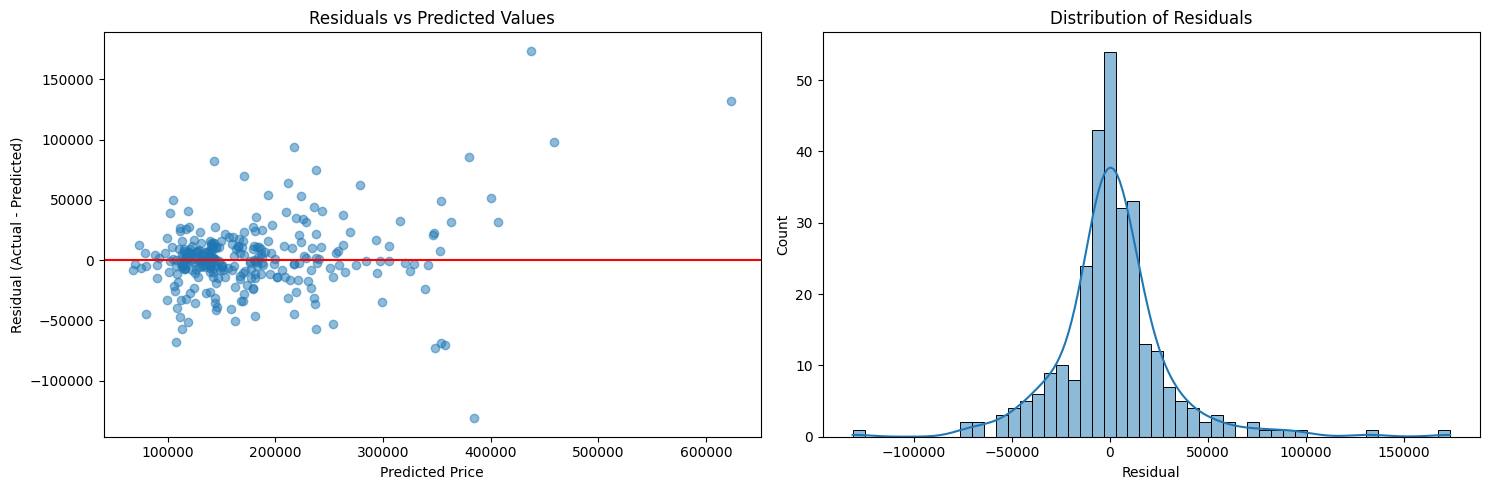

In [ ]:
#i. The models have been fitted on the dataset in question three above

#ii. Also, they have been compared base on their performance using metrics like R2 score and RMSE and we found the random forest(spline-like) model to be be the best.

## iii. Predict house prices for unseen data and compare them with actual prices

# Function to predict for unseen data
def predict_and_evaluate(df, model_results):
    """
    Goal: To Predict house prices for unseen data and evaluate performance
    """
    print("\n--- Predictions and Evaluation ---")

    # Since the random forest works best we chose it
    if 'model' in model_results and model_results['model'] is not None:

        # Prepare a small subset of data as "unseen" data
        X_train, X_test, y_train, y_test = prepare_features_and_target(df)

        # Select important features
        important_features = model_results['feature_order']
        X_test_selected = X_test[important_features]

        # Make predictions
        model = model_results['model']
        y_pred = model.predict(X_test_selected)

        # Create a DataFrame to compare actual and predicted values
        evaluation_df = pd.DataFrame({
            'Actual Price': y_test.values,
            'Predicted Price': y_pred,
            'Difference': y_test.values - y_pred,
            'Percentage Error': abs((y_test.values - y_pred) / y_test.values) * 100
        })

        print("Sample predictions (first 20 rows):")
        print(evaluation_df.head(20))

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mean_abs_percent_error = evaluation_df['Percentage Error'].mean()

        print("\nThe Evaluation Metrics of model performance:")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Mean Absolute Percentage Error: {mean_abs_percent_error:.2f}%")

        # Visualize residuals
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_pred, evaluation_df['Difference'], alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Residuals vs Predicted Values')
        plt.xlabel('Predicted Price')
        plt.ylabel('Residual (Actual - Predicted)')

        plt.subplot(1, 2, 2)
        sns.histplot(evaluation_df['Difference'], kde=True)
        plt.title('Distribution of Residuals')
        plt.xlabel('Residual')

        plt.tight_layout()
        plt.savefig('residual_analysis.png')

        return evaluation_df

    else:
        print("No valid model found in the results.")
        return None

# Predict and evaluate using the best model (Random Forest(spline-like))
if spline_results is not None:
    evaluation_results = predict_and_evaluate(data, spline_results)

#Interpretation:
The Mean Absolute Percentage Error(MAPE) measures the percenatge difference between the actual and predicted values. It is found by taking the average of the absolute percentage errors for each of the prdictions by the model.

The model has a MAPE of **11.50%**, suggesting that on average, the model's predictions are **off** by about 11.50% of the actual house prices.

The value is low and lower MAPE values indicate better model accuracies.

So the value we got suggests a suitable level of accuracy for house price predictions.

This means, the model performed well on the unseen data. It is generalizable as it works well with new data apart from the one it trained on.

## QUESTION FIVE: SIMULATION AND ANALYSIS

In [ ]:
def introduce_hypothetical_scenarios(df, model_results):
    """
    Goal: Introduce hypothetical scenarios and predict their impact on housing prices
    """
    print("\n--- Introducing Hypothetical Scenarios ---")

    if 'model' in model_results and model_results['model'] is not None:
        model = model_results['model']
        important_features = model_results['feature_order']

        # Prepare data
        X_train, X_test, y_train, y_test = prepare_features_and_target(df)
        X_baseline = X_test[important_features].copy()

        # Create baseline prediction
        baseline_predictions = model.predict(X_baseline)
        baseline_avg = np.mean(baseline_predictions)

        # Define detailed hypothetical scenarios
        scenarios = {
            'Population Growth': {
                'description': 'Increased demand due to 15% population growth',
                'changes': {
                    'GrLivArea': 0.05,     # Larger homes being built
                    'LotArea': -0.10,      # Smaller lots due to density
                    'OverallQual': 0.08    # Better quality construction
                }
            },
            'Economic Boom': {
                'description': 'Strong local economy with rising incomes',
                'changes': {
                    'OverallQual': 0.15,   # Higher quality finishes
                    'GrLivArea': 0.12,     # Larger homes
                    'TotalBsmtSF': 0.10,   # More finished basements
                    'GarageArea': 0.08     # Larger garages
                }
            },
            'Infrastructure Development': {
                'description': 'Major infrastructure improvements in the area',
                'changes': {
                    'Neighborhood': 0.12,  # Neighborhood improvement
                    'Condition1': 0.08,    # Better proximity features
                    'ExterQual': 0.05      # Better exterior materials
                }
            },
            'Housing Market Recession': {
                'description': 'Economic downturn affecting housing market',
                'changes': {
                    'OverallQual': -0.05,  # Lower quality finishes
                    'GrLivArea': -0.03,    # Smaller homes being built
                    'SaleCondition': -0.10 # More distressed sales
                }
            }
        }

        scenario_results = []

        for scenario_name, scenario_info in scenarios.items():
            # Create a copy of the baseline data
            X_scenario = X_baseline.copy()

            # Apply changes according to the scenario
            for feature, change in scenario_info['changes'].items():
                if feature in X_scenario.columns:
                    X_scenario[feature] = X_scenario[feature] * (1 + change)

            # Make predictions
            scenario_predictions = model.predict(X_scenario)
            avg_prediction = np.mean(scenario_predictions)

            # Calculate change from baseline
            percent_change = ((avg_prediction - baseline_avg) / baseline_avg) * 100

            scenario_results.append({
                'Scenario': scenario_name,
                'Description': scenario_info['description'],
                'Average Price': avg_prediction,
                'Change from Baseline (%)': percent_change
            })

            print(f"Scenario: {scenario_name}")
            print(f"  Description: {scenario_info['description']}")
            print(f"  Average predicted price: ${avg_prediction:.2f}")
            print(f"  Change from baseline: {percent_change:.2f}%")

        # Create a DataFrame for visualization
        scenario_df = pd.DataFrame(scenario_results)

        # Visualize scenarios with more details
        plt.figure(figsize=(14, 10))

        plt.subplot(2, 1, 1)
        sns.barplot(x='Scenario', y='Average Price', data=scenario_df)
        plt.title('Average Predicted Price by Scenario')
        plt.xticks(rotation=45)
        plt.ylabel('Average Price ($)')

        plt.subplot(2, 1, 2)
        sns.barplot(x='Scenario', y='Change from Baseline (%)', data=scenario_df)
        plt.title('Percentage Change from Baseline')
        plt.xticks(rotation=45)
        plt.ylabel('Change (%)')
        plt.axhline(y=0, color='r', linestyle='--')

        plt.tight_layout()
        plt.savefig('hypothetical_scenarios.png')


        plt.figure(figsize=(12, 8))

        # Group houses into price ranges
        price_ranges = pd.qcut(y_test, 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
        X_test_copy = X_test.copy()
        X_test_copy['PriceRange'] = price_ranges

        # Analyzing one scenario impact across price ranges
        key_scenario = 'Economic Boom'
        key_scenario_changes = scenarios[key_scenario]['changes']

        impacts = []

        for price_range in ['Low', 'Medium-Low', 'Medium-High', 'High']:
            # Filter data for this price range
            range_indices = X_test_copy[X_test_copy['PriceRange'] == price_range].index
            X_range = X_baseline.loc[range_indices]

            # Baseline prediction
            range_baseline_pred = model.predict(X_range)

            # Modified prediction
            X_range_mod = X_range.copy()
            for feature, change in key_scenario_changes.items():
                if feature in X_range_mod.columns:
                    X_range_mod[feature] = X_range_mod[feature] * (1 + change)

            range_mod_pred = model.predict(X_range_mod)

            # Calculate percent change
            pct_change = ((np.mean(range_mod_pred) - np.mean(range_baseline_pred)) /
                          np.mean(range_baseline_pred)) * 100

            impacts.append({
                'Price Range': price_range,
                'Percent Change': pct_change
            })

        impact_df = pd.DataFrame(impacts)

        # Plot impact by price range
        sns.barplot(x='Price Range', y='Percent Change', data=impact_df)
        plt.title(f'Impact of "{key_scenario}" Scenario by House Price Range')
        plt.ylabel('Percent Change in Price (%)')
        plt.axhline(y=0, color='r', linestyle='--')

        plt.tight_layout()
        plt.savefig('scenario_impact_by_price_range.png')


        return scenario_df

    else:
        print("No valid model found in the results.")
        return None


--- Introducing Hypothetical Scenarios ---
Scenario: Population Growth
  Description: Increased demand due to 15% population growth
  Average predicted price: $190718.43
  Change from baseline: 7.45%
Scenario: Economic Boom
  Description: Strong local economy with rising incomes
  Average predicted price: $204618.19
  Change from baseline: 15.29%
Scenario: Infrastructure Development
  Description: Major infrastructure improvements in the area
  Average predicted price: $177487.27
  Change from baseline: 0.00%
Scenario: Housing Market Recession
  Description: Economic downturn affecting housing market
  Average predicted price: $175237.90
  Change from baseline: -1.27%


,Scenario,Description,Average Price,Change from Baseline (%)
0,Population Growth,Increased demand due to 15% population growth,190718.425038,7.454708
1,Economic Boom,Strong local economy with rising incomes,204618.192626,15.286125
2,Infrastructure Development,Major infrastructure improvements in the area,177487.266990,0.000000
3,Housing Market Recession,Economic downturn affecting housing market,175237.896830,-1.267342


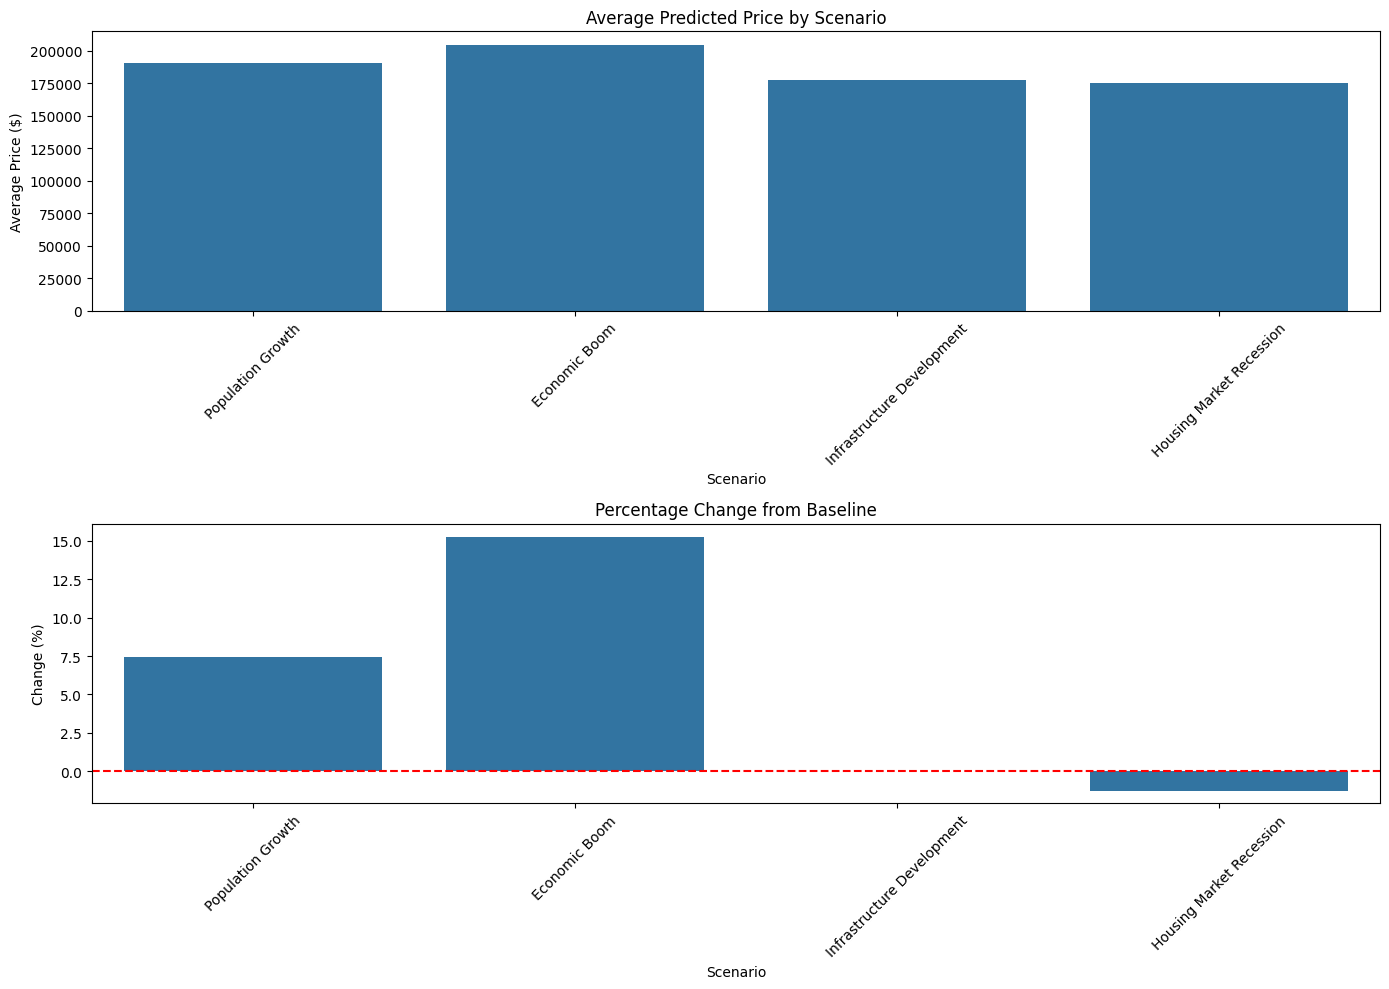

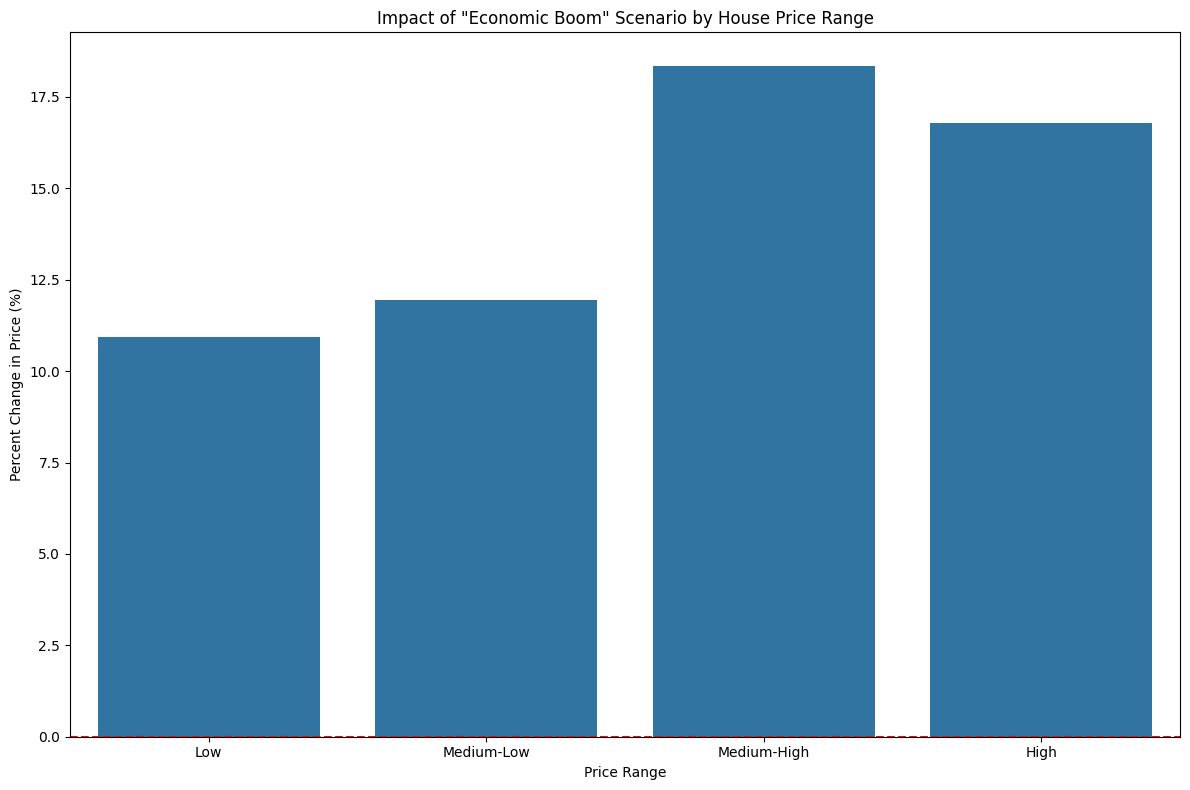

In [ ]:
introduce_hypothetical_scenarios(data, spline_results)

### Sensitivity Analysis

In [ ]:
def perform_sensitivity_analysis(df, model_results):
    """
    Goal: Perform sensitivity analysis to determine which factors influence the price the most
    """
    print("\n--- Sensitivity Analysis ---")

    if 'model' in model_results and model_results['model'] is not None:
        model = model_results['model']

        # Get top features from the model
        important_features = model_results['feature_order']

        X_train, X_test, y_train, y_test = prepare_features_and_target(df)
        X_baseline = X_test[important_features].copy()

        # Create baseline prediction
        baseline_predictions = model.predict(X_baseline)
        baseline_avg = np.mean(baseline_predictions)

        sensitivity_results = []

        # Test sensitivity by changing each feature independently
        change_amounts = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20% changes

        for feature in important_features:
            feature_sensitivity = []

            for change in change_amounts:
                # Create copies for positive and negative changes
                X_pos_change = X_baseline.copy()
                X_neg_change = X_baseline.copy()

                # Apply changes
                X_pos_change[feature] = X_pos_change[feature] * (1 + change)
                X_neg_change[feature] = X_neg_change[feature] * (1 - change)

                # Make predictions
                pos_predictions = model.predict(X_pos_change)
                neg_predictions = model.predict(X_neg_change)

                # Calculate average changes
                pos_avg = np.mean(pos_predictions)
                neg_avg = np.mean(neg_predictions)

                # Calculate percent changes
                pos_pct_change = ((pos_avg - baseline_avg) / baseline_avg) * 100
                neg_pct_change = ((neg_avg - baseline_avg) / baseline_avg) * 100

                # Store results
                feature_sensitivity.append({
                    'Feature': feature,
                    'Change': f'+{change*100}%',
                    'Percent Impact': pos_pct_change
                })

                feature_sensitivity.append({
                    'Feature': feature,
                    'Change': f'-{change*100}%',
                    'Percent Impact': neg_pct_change
                })

            # Calculate average sensitivity (average absolute impact across all changes)
            avg_sensitivity = np.mean([abs(item['Percent Impact']) for item in feature_sensitivity])

            sensitivity_results.append({
                'Feature': feature,
                'Average Sensitivity': avg_sensitivity,
                'Details': feature_sensitivity
            })

        # Sort the results by average sensitivity
        sensitivity_results.sort(key=lambda x: x['Average Sensitivity'], reverse=True)

        print("Features ranked by sensitivity (impact on price):")
        for i, result in enumerate(sensitivity_results, 1):
            print(f"{i}. {result['Feature']}: {result['Average Sensitivity']:.2f}% average impact")

        # Prepare data for visualization
        sensitivity_df = pd.DataFrame([
            {'Feature': result['Feature'], 'Average Sensitivity': result['Average Sensitivity']}
            for result in sensitivity_results
        ])

        # Detailed dataframe for all changes
        detailed_df = pd.DataFrame([
            item for result in sensitivity_results for item in result['Details']
        ])


        plt.figure(figsize=(12, 8))

        # Plot average sensitivity
        sns.barplot(x='Average Sensitivity', y='Feature', data=sensitivity_df)
        plt.title('Feature Sensitivity: Average Impact on House Price')
        plt.xlabel('Average Absolute Percent Change in Price')
        plt.tight_layout()
        plt.savefig('feature_sensitivity.png')

        # Plot detailed sensitivity for top 5 features
        plt.figure(figsize=(14, 10))
        top_features = sensitivity_df['Feature'].head(5).tolist()
        top_details = detailed_df[detailed_df['Feature'].isin(top_features)]

        sns.catplot(
            x='Change', y='Percent Impact', hue='Feature',
            data=top_details, kind='bar', height=6, aspect=1.5
        )
        plt.title('Detailed Sensitivity Analysis for Top 5 Features')
        plt.xlabel('Percent Change in Feature')
        plt.ylabel('Percent Impact on Price')
        plt.tight_layout()
        plt.savefig('detailed_sensitivity.png')

        # Create a heatmap of feature sensitivities
        plt.figure(figsize=(12, 8))
        pivot_data = detailed_df.pivot_table(
            index='Feature',
            columns='Change',
            values='Percent Impact'
        )

        sns.heatmap(pivot_data, annot=True, cmap='coolwarm', center=0, fmt='.1f')
        plt.title('Sensitivity Heatmap: Impact of Feature Changes on Price')
        plt.tight_layout()
        plt.savefig('sensitivity_heatmap.png')

        return sensitivity_results

    else:
        print("No valid model found in the results.")
        return None


--- Sensitivity Analysis ---
Features ranked by sensitivity (impact on price):
1. OverallQual: 6.33% average impact
2. YearBuilt: 4.44% average impact
3. GrLivArea: 3.83% average impact
4. YearRemodAdd: 2.51% average impact
5. TotalBsmtSF: 1.99% average impact
6. GarageYrBlt: 1.48% average impact
7. 1stFlrSF: 1.15% average impact
8. LotArea: 0.83% average impact
9. GarageArea: 0.82% average impact
10. TotRmsAbvGrd: 0.19% average impact
11. GarageCars: 0.12% average impact
12. MasVnrArea: 0.07% average impact
13. FullBath: 0.03% average impact
14. Fireplaces: 0.00% average impact
15. ExterQual_TA: 0.00% average impact
16. KitchenQual_TA: 0.00% average impact
17. GarageFinish_Unf: 0.00% average impact
18. BsmtQual_TA: 0.00% average impact
19. Foundation_PConc: 0.00% average impact
20. ExterQual_Gd: 0.00% average impact


[{'Feature': 'OverallQual',
  'Average Sensitivity': np.float64(6.3305002655115565),
  'Details': [{'Feature': 'OverallQual',
    'Change': '+5.0%',
    'Percent Impact': np.float64(0.0141479375377849)},
   {'Feature': 'OverallQual',
    'Change': '-5.0%',
    'Percent Impact': np.float64(-0.16255287242769156)},
   {'Feature': 'OverallQual',
    'Change': '+10.0%',
    'Percent Impact': np.float64(7.985863039205798)},
   {'Feature': 'OverallQual',
    'Change': '-10.0%',
    'Percent Impact': np.float64(-6.5103825363011065)},
   {'Feature': 'OverallQual',
    'Change': '+15.0%',
    'Percent Impact': np.float64(9.336921427935204)},
   {'Feature': 'OverallQual',
    'Change': '-15.0%',
    'Percent Impact': np.float64(-7.082341605684725)},
   {'Feature': 'OverallQual',
    'Change': '+20.0%',
    'Percent Impact': np.float64(9.76843629170354)},
   {'Feature': 'OverallQual',
    'Change': '-20.0%',
    'Percent Impact': np.float64(-9.783356413296605)}]},
 {'Feature': 'YearBuilt',
  'Aver

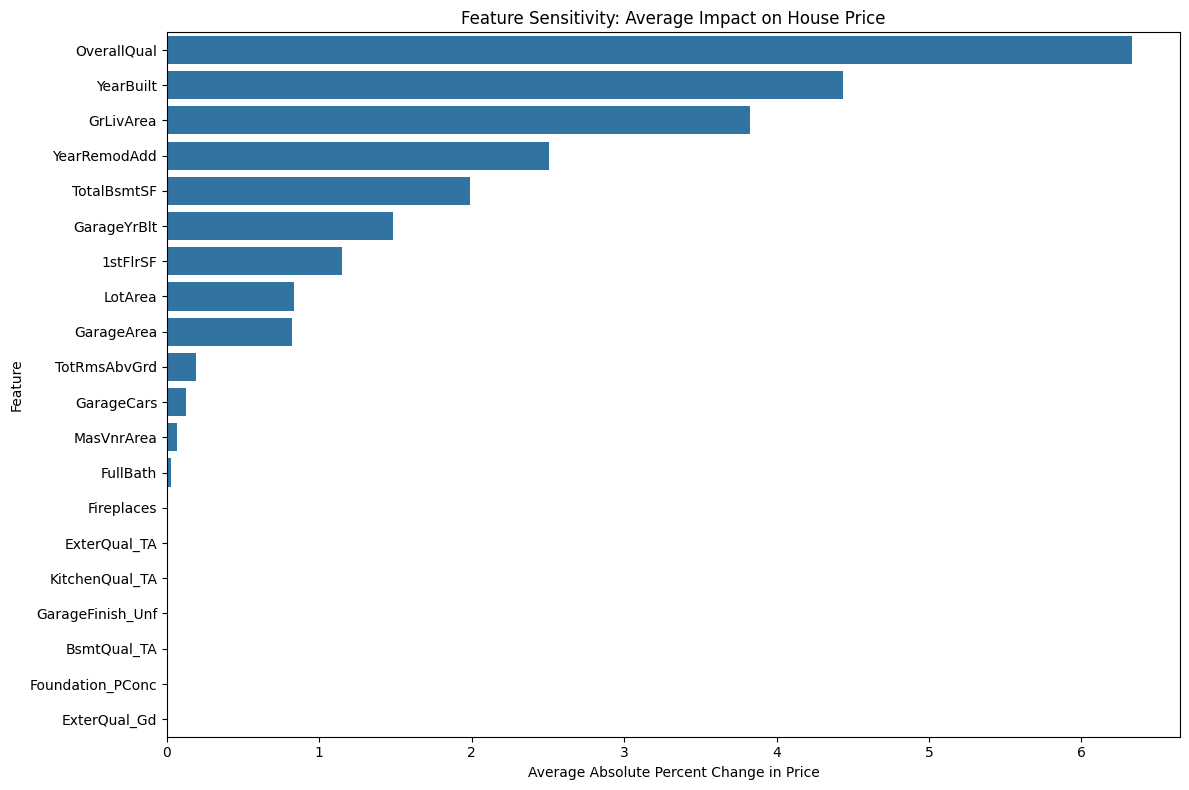

<Figure size 1400x1000 with 0 Axes>

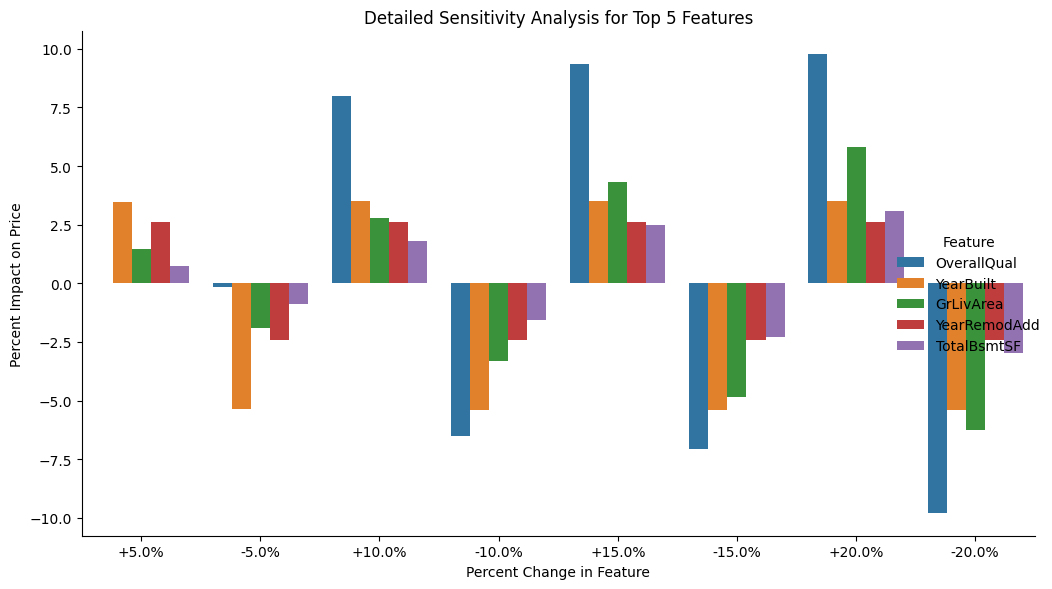

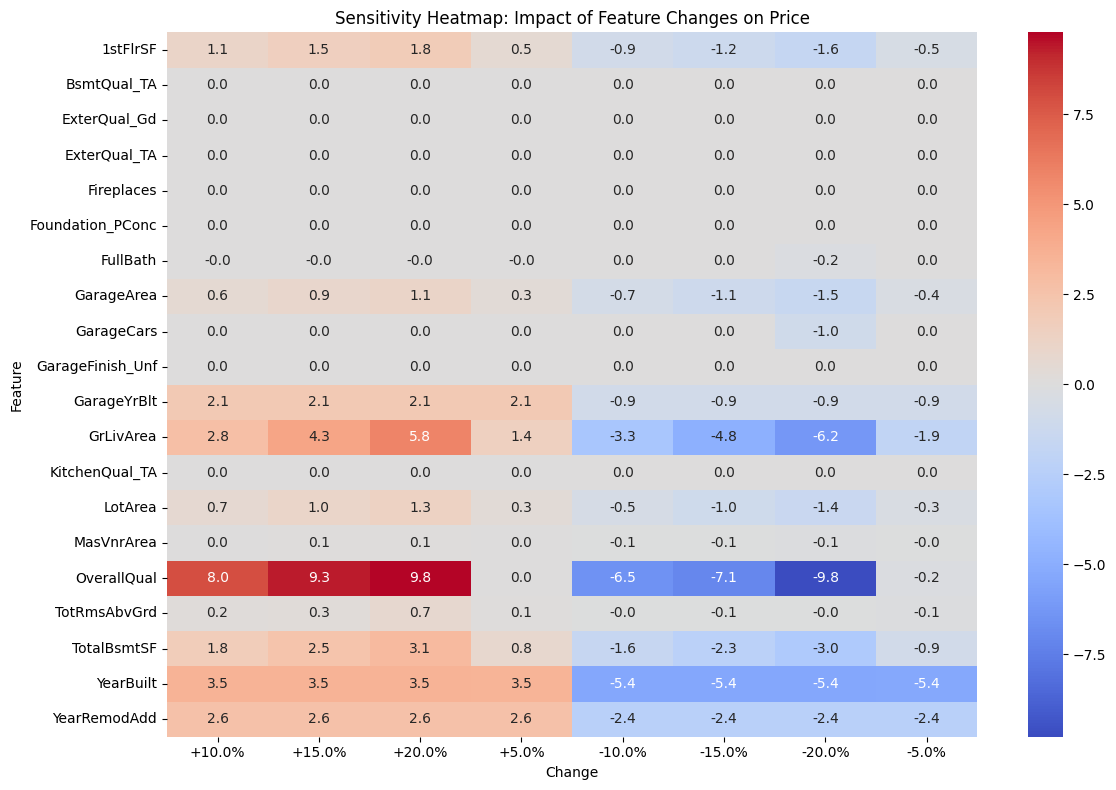

In [ ]:
perform_sensitivity_analysis(data, spline_results)

## QUESTION SIX: SUGGESTIONS FOR MODEL IMPROVEMENT

### Fine-tune model parameters for better accuracy

In [ ]:
def suggest_model_improvements(df, model_results):
    """
    Provide suggestions for model improvement including fine-tuning parameters,
    comparing models, and discussing limitations
    """
    if 'model' in model_results and model_results['model'] is not None and isinstance(model_results['model'], RandomForestRegressor):
        model = model_results['model']

        # Prepare data
        X_train, X_test, y_train, y_test = prepare_features_and_target(df)
        important_features = model_results['feature_order']
        X_train = X_train[important_features]
        X_test = X_test[important_features]

        # Current model performance
        y_pred = model.predict(X_test)
        current_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        current_r2 = r2_score(y_test, y_pred)

        print(f"Current model performance: RMSE = {current_rmse:.2f}, R² = {current_r2:.4f}")

        # Define parameter combinations to try for different outcomes to compare
        param_combinations = [
            {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2},
            {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 5},
            {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 8},
            {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 3}
        ]

        tuning_results = []

        print("\nTesting different parameter combinations:")
        for i, params in enumerate(param_combinations, 1):
            # Create and train model with these parameters
            tuned_model = RandomForestRegressor(
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_samples_split=params['min_samples_split'],
                random_state=42
            )

            tuned_model.fit(X_train, y_train)

            # Make predictions and evaluate
            y_pred = tuned_model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            tuning_results.append({
                'Parameters': params,
                'RMSE': rmse,
                'R²': r2
            })

            print(f"  Model {i}: {params}")
            print(f"    RMSE: {rmse:.2f}, R²: {r2:.4f}")

        # Find best model
        best_model_idx = min(range(len(tuning_results)), key=lambda i: tuning_results[i]['RMSE'])
        best_params = tuning_results[best_model_idx]['Parameters']
        best_rmse = tuning_results[best_model_idx]['RMSE']
        best_r2 = tuning_results[best_model_idx]['R²']

        print(f"\nBest parameter combination: {best_params}")
        print(f"Best model performance: RMSE = {best_rmse:.2f}, R² = {best_r2:.4f}")

        improvement = ((current_rmse - best_rmse) / current_rmse) * 100
        print(f"Improvement over current model: {improvement:.2f}%")



In [ ]:
suggest_model_improvements(data, spline_results)

Current model performance: RMSE = 28902.98, R² = 0.8911

Testing different parameter combinations:
  Model 1: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
    RMSE: 28902.98, R²: 0.8911
  Model 2: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 5}
    RMSE: 29429.02, R²: 0.8871
  Model 3: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 8}
    RMSE: 30052.44, R²: 0.8823
  Model 4: {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 3}
    RMSE: 28778.62, R²: 0.8920

Best parameter combination: {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 3}
Best model performance: RMSE = 28778.62, R² = 0.8920
Improvement over current model: 0.43%


## INTERPRETATION:

After fine-tuning the current model, it improved by about 0.43%.
- The R2 score increased from **0.8911 to 0.8920.**
- The RMSE reduced from **28902.98 to 28778.62**

### Comparing different Models

In [ ]:
# Prepare data
X_train, X_test, y_train, y_test = prepare_features_and_target(data)

# Accessing the spline_results dictionary to get 'feature_order'
important_features = spline_results['feature_order']
X_train = X_train[important_features]
X_test = X_test[important_features]

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R²': r2})

results_df = pd.DataFrame(results)

print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 20
[LightGBM] [Info] Start training from score 181441.541952
               Model          RMSE        R²
0      Random Forest  28902.976695  0.891089
1  Gradient Boosting  30085.453540  0.881995
2                SVR  88640.782849 -0.024362
3            XGBoost  33150.401506  0.856727
4           LightGBM  32339.170555  0.863654


## Interpretation:

Random Forest(spline-like) is the best performed model after being compared with other non-linear models like Gradient Boosting, SVR, XGBoost and LightGBM.


It has a lower RMSE, indidcating a better predictive accuracy

Its higher R2 score suggests that the model explains a greater proportion of variance in the target variable(SalePrice of houses)


The model has been able to handle the non-linear relationships and the complexity of the dataset.

### POTENTIAL LIMITATIONS:
1. Overfitting: Most non-linear models like Random Forest that have high flexibility can be prone to ovefitting.
The model might perform very well on the training data but may generalize poorly to unseen data.
Even though the model seemed to work well on the unseen data ealier but it may not be the case always.

2. Data Dependency: The non-linear models may be heavily reliant on the quality the trianing data. Possible biases, inaccuracies, missing values and other issues may lead to unreliable predictions which do not represent the real-world scenario of housing prices well.

3. Challenge in interpreting the actual reltionship existing between the featres and the target.

4. Other specific market dynamics, some of which might not have been captured by the dataset can lead to unreliable predictions.



### ALTERNATIVE MODELING APPROACHES:

- Using time series models to capture temporal dependencies and predict future housing price trends for data over time.

- Using hybrid models that combine predictions from different models to leverage the strengths of each of the models to improve overall accuracy.

- Neural networks which can learn more complex non-linear realtionships.



### Policy Insights and Recommendations

- Encourage Redevelopment of Aged Housing Stock: Older housing units tend to have lower market value and may not meet current building or energy standards. Policymakers should support redevelopment through incentives like tax breaks or expedited permits. This can help revitalize neighborhoods, improve housing quality, and increase property values.

- Prioritise Infrastructure in High-Potential Areas: Infrastructure improvements, such as roads, drainage, transit, and utilities, were shown to positively impact housing prices. Strategic investment in these areas can stimulate demand, attract private development, and enhance overall urban connectivity.

- Implement Data-Driven Urban Planning: Use predictive modeling and real-time data to guide zoning decisions, identify areas with high growth potential, and plan affordable housing initiatives. Data-driven planning reduces mismatches in supply and demand and allows for more responsive policy interventions.

- Create a Centralised Housing Price Monitoring System: Develop a digital platform to track housing prices, inventory levels, and demand-supply gaps across regions. This system would support transparency, inform both public and private stakeholders, and enable early intervention in overheated or underserved markets.